# Mood-Based Playlist Generator: A Music Recommendation System

* Build a playlist recommendation system that suggests songs based on mood categories
* Use clustering models to group songs by mood, leveraging acoustic features (valence, energy, tempo).
* Personalize playlists by allowing users to input their mood, and get dynamic song recommendations.

# Business Understanding

# Data Understanding

In [31]:
pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   --------------------------------------- 920.8/920.8 kB 14.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

In [2]:
df=pd.read_csv('./data.csv')
df

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


In [3]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [4]:
df.shape

(2017, 17)

In [5]:
df.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


# Data Preparation

* Clean and normalize acoustic features like valence, energy, tempo, danceability.
* Use NLP to extract sentiment scores from lyrics — add emotional tone as a feature.
* Encode genres and artist names.

Data Cleaning: Remove duplicate songs, handle missing values (e.g., songs without tempo or valence data), and standardize song attributes (like scaling tempo and energy).


In [6]:
# Select relevant features for clustering
acoustic_features = ['valence', 'energy', 'tempo', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
df_features = df[acoustic_features]

In [7]:
# Handle missing values (simple imputation)
df_features = df_features.fillna(df_features.median())

In [8]:
# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

## Finding Optimal Number of Clusters

k=2, Inertia=13387.706821848562
k=3, Inertia=11630.827929614212
k=4, Inertia=10304.908283353734
k=5, Inertia=9391.201711613841
k=6, Inertia=8753.022892078972
k=7, Inertia=7799.371747015971
k=8, Inertia=7334.023057658946
k=9, Inertia=7077.84091712243
k=10, Inertia=6829.573564143784


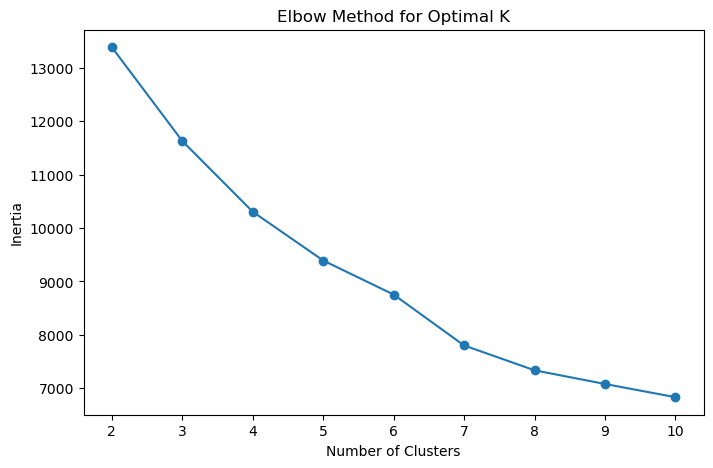

In [9]:
# Determine optimal number of clusters using Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    print(f'k={k}, Inertia={kmeans.inertia_}')  # Print inertia values

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


The elbow is around k=5, because the inertia drop slows down significantly after k=5.
If you want fewer clusters, go with k=4 (simpler, broader mood categories). 5 clusters will give us the best balance between distinct clusters and efficiency.

# K Means Clustering

In [10]:
# Set optimal k
optimal_k = 5

# Train final KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto', algorithm='elkan')

# Assign clusters
df["Mood_Cluster"] = kmeans.fit_predict(df_scaled)

In [11]:
df['Mood_Cluster'] = df['Mood_Cluster'].astype(int)

In [12]:
df.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist,Mood_Cluster
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future,2
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino,0
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future,2
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House,3
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys,4


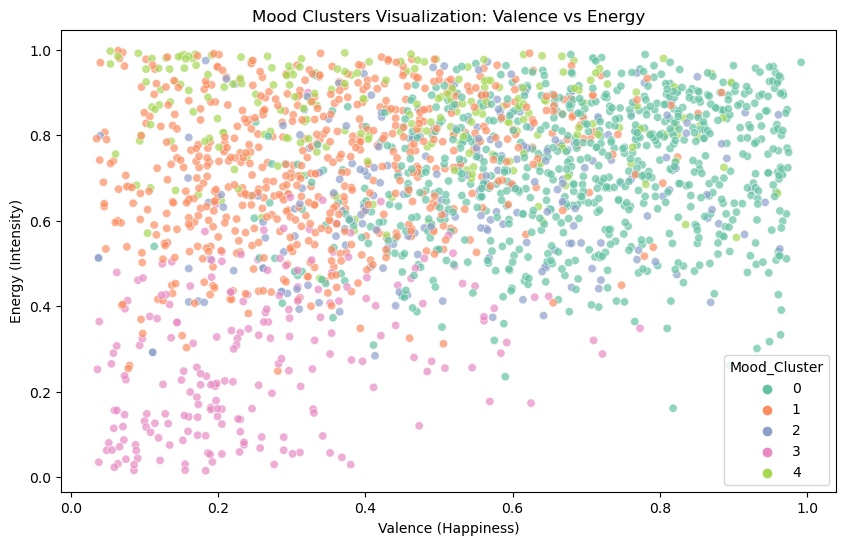

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["valence"], y=df["energy"], hue=df["Mood_Cluster"], palette="Set2", alpha=0.7)
plt.title("Mood Clusters Visualization: Valence vs Energy")
plt.xlabel("Valence (Happiness)")
plt.ylabel("Energy (Intensity)")
plt.show()

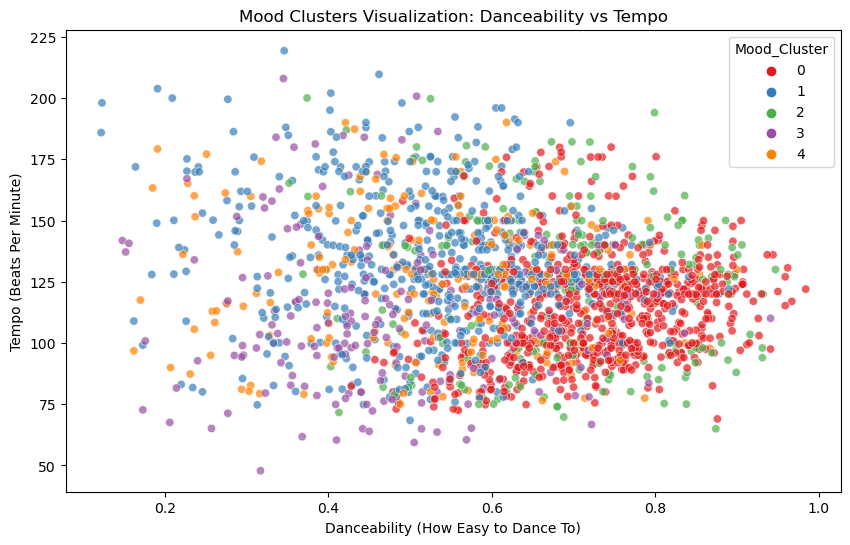

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["danceability"], y=df["tempo"], hue=df["Mood_Cluster"], palette="Set1", alpha=0.7)
plt.title("Mood Clusters Visualization: Danceability vs Tempo")
plt.xlabel("Danceability (How Easy to Dance To)")
plt.ylabel("Tempo (Beats Per Minute)")
plt.show()

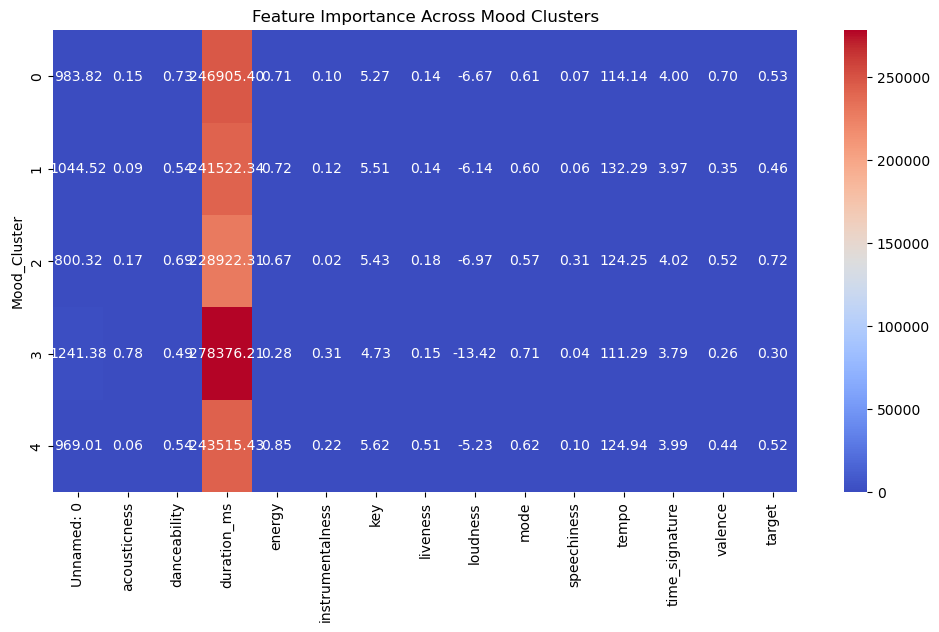

In [15]:
# Select only numeric columns (exclude song titles, artists, etc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Exclude "Mood_Cluster" itself from mean calculation
numeric_cols = [col for col in numeric_cols if col != "Mood_Cluster"]

# Compute the mean for each numeric feature per cluster
cluster_means = df.groupby("Mood_Cluster")[numeric_cols].mean()

# Now plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Importance Across Mood Clusters")
plt.show()

## Silhouette Score - Evaluating the Clusters
Measures how similar a data point is to its own cluster vs. other clusters.

In [16]:
# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(df_scaled, df["Mood_Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.1759


Our score of 0.1759 is relatively low. We want to get it closer to 0.5.

In [17]:
df

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist,Mood_Cluster
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future,2
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino,0
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future,2
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House,3
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise,2
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis,0
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man,1
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons,1


# Improving our Clusters

### Check for Correlated Features

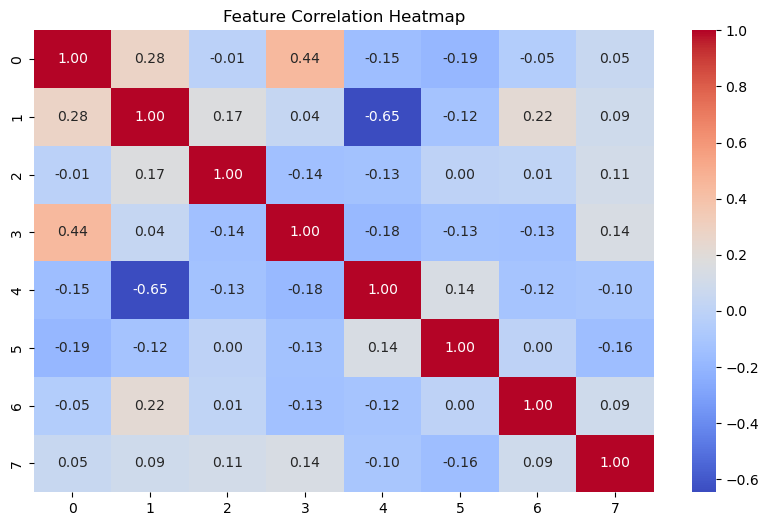

In [18]:
# Check correlation to consider dropping features that are highly correlated
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(df_scaled).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Try DBSCAN instead of KMeans

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
df["Mood_Cluster"] = dbscan.fit_predict(df_scaled)

silhouette_avg = silhouette_score(df_scaled, df["Mood_Cluster"])
print(f"New Silhouette Score with DBSCAN: {silhouette_avg:.4f}")


New Silhouette Score with DBSCAN: 0.1507


### Try Agglomerative Clustering instead of KMeans

In [20]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=5)
df["Mood_Cluster"] = agglo.fit_predict(df_scaled)

silhouette_avg = silhouette_score(df_scaled, df["Mood_Cluster"])
print(f"New Silhouette Score with Agglomerative Clustering: {silhouette_avg:.4f}")

New Silhouette Score with Agglomerative Clustering: 0.1698


### Try Removing Outliers before Clustering

In [21]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_scaled)

# Keep only non-outliers
df_cleaned = df[outliers == 1]
df_scaled_cleaned = df_scaled[outliers == 1]

In [22]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto', algorithm='elkan')
df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)

silhouette_avg = silhouette_score(df_scaled_cleaned, df_cleaned["Mood_Cluster"])
print(f"Silhouette Score after removing outliers: {silhouette_avg:.4f}")


Silhouette Score after removing outliers: 0.1786


C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32284\349517368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)


### Take only the Most Important Features

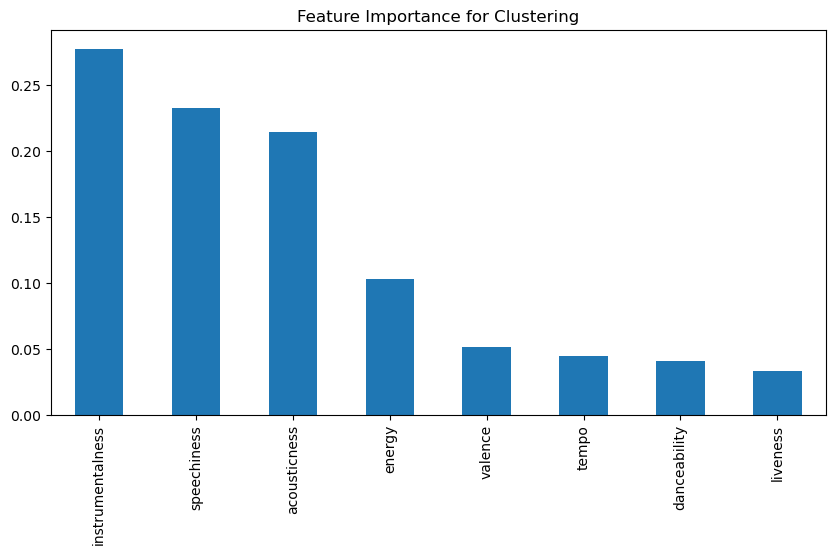

In [25]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Model to find feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_scaled, df["Mood_Cluster"])  # Fit model to clusters

# Use the correct feature names from df_scaled
feature_names = ['valence', 'energy', 'tempo', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=feature_names)

# Plot feature importance
importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Feature Importance for Clustering")
plt.show()


In [26]:
import pandas as pd

# Convert df_scaled back to a DataFrame
df_scaled_df = pd.DataFrame(df_scaled, columns=feature_names)  # Use correct feature names

# Get the top 5 most important features
top_features = importances.nlargest(5).index

# Select only the top features from the scaled DataFrame
df_selected = df_scaled_df[top_features]

# Re-run K-Means on the selected features
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto', algorithm='elkan')
df["Mood_Cluster"] = kmeans.fit_predict(df_selected)

# Check the new Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df_selected, df["Mood_Cluster"])
print(f"New Silhouette Score after feature selection: {silhouette_avg:.4f}")

New Silhouette Score after feature selection: 0.3020


With 5 clusters, our Silhouette score is still too low. Let's see what the optimal number of clusters is to raise this score.

### After Feature Selection Find Optimal Number of Clusters

Silhouette Score for k=2: 0.3816
Silhouette Score for k=3: 0.2221
Silhouette Score for k=4: 0.2597
Silhouette Score for k=5: 0.3020
Silhouette Score for k=6: 0.3114
Silhouette Score for k=7: 0.2805
Silhouette Score for k=8: 0.2760
Silhouette Score for k=9: 0.2704
Silhouette Score for k=10: 0.2722


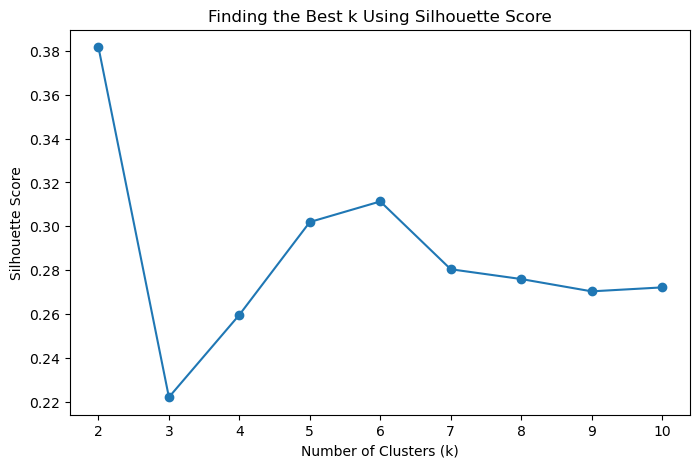

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 11)  # Try from k=2 to k=10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    clusters = kmeans.fit_predict(df_selected)
    score = silhouette_score(df_selected, clusters)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Finding the Best k Using Silhouette Score")
plt.show()


The optimal number of clusters is 2 according to this graph, but we want more than 2 playlists. We will split into 2 clusters and then from there, make sub clusters.

In [33]:
import skfuzzy as fuzz
import numpy as np

# Define number of clusters
num_clusters = 5  # Adjust if needed

# Run Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    df_selected.T,  # Transpose because FCM expects features as rows
    c=num_clusters,  # Number of clusters
    m=2,             # Fuzziness parameter (higher = softer clustering)
    error=0.005,     # Stopping criterion
    maxiter=1000,    # Max iterations
    init=None
)

# Assign each song to the cluster with the highest probability
df["Mood_Cluster"] = np.argmax(u, axis=0)

# Show probability of belonging to each cluster
df_fc_probs = pd.DataFrame(u.T, columns=[f"Cluster_{i}" for i in range(num_clusters)])
df = pd.concat([df, df_fc_probs], axis=1)

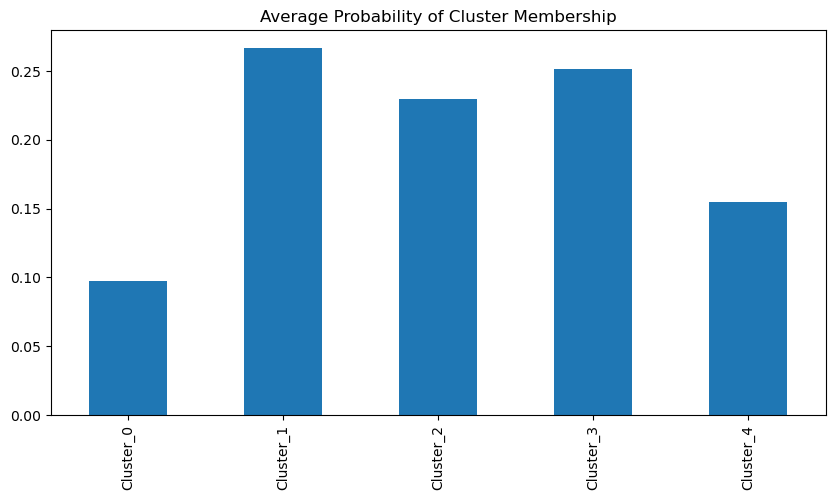

In [34]:
df_fc_probs.mean().plot(kind="bar", figsize=(10, 5), title="Average Probability of Cluster Membership")
plt.show()


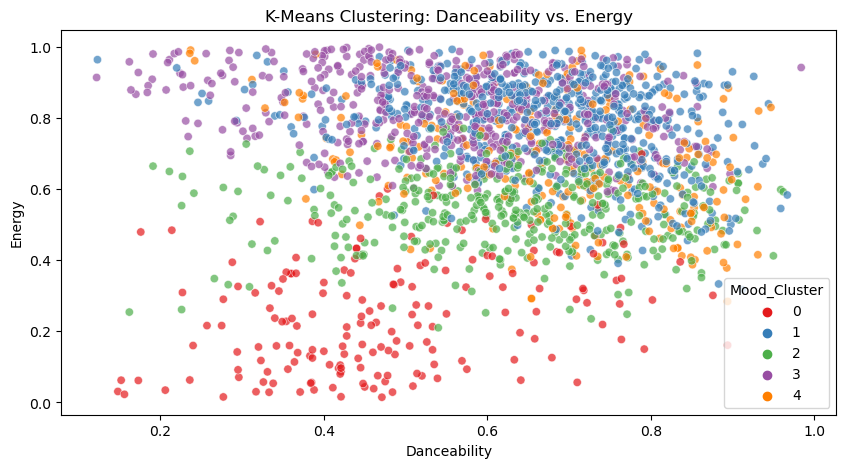

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["danceability"], y=df["energy"], hue=df["Mood_Cluster"], palette="Set1", alpha=0.7)
plt.title("K-Means Clustering: Danceability vs. Energy")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.show()

In [37]:
df[["song_title", "artist", "Mood_Cluster", "Cluster_0", "Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"]].sample(10)


,song_title,artist,Mood_Cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
637,For Your Love - Club Edit,The Partysquad,2,0.020667,0.114547,0.454762,0.311470,0.098553
1127,Al Filo de Tu Amor,Carlos Vives,1,0.016657,0.712770,0.095377,0.110590,0.064606
706,Can We Go Up?,Paper Diamond,1,0.008047,0.743680,0.097662,0.114963,0.035648
1622,Summer,Marshmello,3,0.022863,0.095374,0.240925,0.587006,0.053832
887,Deeper Than Love,Colleen Green,1,0.135702,0.252778,0.236951,0.200566,0.174004
1399,Summer Night You and I,Standing Egg,0,0.380015,0.144503,0.213156,0.136033,0.126293
1541,Two Sleepy People,Marcus Gilmore,0,0.685512,0.068056,0.096095,0.077829,0.072508
583,Do You Like It? (Feat. Kool A.D),Chaz Van Queen,4,0.061721,0.116849,0.126926,0.116388,0.578116
983,Treat Me Like Fire,LION BABE,2,0.010450,0.055485,0.576115,0.322341,0.035609
1336,The Call of Mighty,Crucify Me Gently,3,0.068176,0.166776,0.230322,0.396009,0.138718


In [38]:
# Get songs that strongly belong to a mood (e.g., at least 0.6 probability)
mood_threshold = 0.6

for i in range(num_clusters):
    print(f"\n🎵 Mood {i} Playlist 🎵")
    display(df[df[f"Cluster_{i}"] > mood_threshold][["song_title", "artist"]].sample(5))


🎵 Mood 0 Playlist 🎵


,song_title,artist
1554,Where Do You Start,Brad Mehldau Trio
1540,Good Morning Heartache,Scott Hamilton
1546,Almas vaggvisa,Jan Lundgren Trio
1542,Can't Help Loving,Beegie Adair
1552,Doubts 2,Ibrahim Maalouf



🎵 Mood 1 Playlist 🎵


,song_title,artist
827,Easy Rider,Action Bronson
1714,Big Time Rush,Big Time Rush
392,Never Never Gonna Give Ya Up,Barry White
1775,"Jumpin', Jumpin'",Destiny's Child
1634,Light It Up (feat. Nyla & Fuse ODG) [Remix],Major Lazer



🎵 Mood 2 Playlist 🎵


,song_title,artist
617,Sweater Weather,The Neighbourhood
1890,What's Up?,4 Non Blondes
998,Father Stretch My Hands Pt. 1,Kanye West
1221,Do I Wanna Know?,Arctic Monkeys
1707,Without Me,Kina Grannis



🎵 Mood 3 Playlist 🎵


,song_title,artist
1504,Confident,Demi Lovato
515,We Own The Sky,M83
1606,Last Chance,Kaskade
1799,Why Can't I?,Liz Phair
288,"The New International Sound, Pt. 2 (feat. M.I.A.)",GENER8ION



🎵 Mood 4 Playlist 🎵


,song_title,artist
588,Oldie,Odd Future
478,Love In Motion - feat. Mayer Hawthorne,Sebastian
792,Tuesday,ILoveMakonnen
1674,Calm Down,G-Eazy
1498,Human,Rag'n'Bone Man


In [ ]:
# How many songs fall into each cluster?
print(df['Mood_Cluster'].value_counts())

In [ ]:
# Select only numeric columns for mean calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Extract numeric columns
numeric_cols = numeric_cols[numeric_cols != "Mood_Cluster"]  # Exclude Mood_Cluster itself

# Compute the mean for each cluster using only numeric features
cluster_means = df.groupby('Mood_Cluster')[numeric_cols].mean()

# Display the results
cluster_means

Feature	High Values Mean...	Low Values Mean...
Valence (0-1)	Happy, cheerful, uplifting	Sad, melancholic
Energy (0-1)	Loud, fast, energetic	Soft, slow, relaxed
Tempo (BPM)	Fast-paced	Slow, chill
Danceability (0-1)	Easy to dance to	Hard to dance to
Acousticness	Acoustic, unplugged feel	Electronic, heavily produced
Liveness	Live performance	Studio recording

In [ ]:
# Manually label clusters based on analysis
mood_labels = {
    0: "Feel Good",
    1: "Workout Pump",
    2: "Calm Cool Collected",
    3: "In my Feels",
    4: "Hype Party"
}

# Add the mood label to the dataset
df["Mood_Label"] = df["Mood_Cluster"].map(mood_labels)

# Show a preview
df[["song_title", "artist", "Mood_Cluster", "Mood_Label"]].head()

## Examples of Songs in Each Playlist

In [ ]:
for cluster in sorted(df["Mood_Cluster"].unique()):
    print(f"\n Mood Cluster {cluster} – {mood_labels[cluster]}")
    display(df[df["Mood_Cluster"] == cluster][["song_title", "artist"]].sample(5))

In [ ]:
# Function to display songs from a selected mood
def display_playlist(mood):
    display(df[df["Mood_Label"] == mood][["song_title", "artist"]].sample(5))

# Create dropdown menu for mood selection
mood_dropdown = widgets.Dropdown(
    options=df["Mood_Label"].unique(),
    description="Choose Mood:",
    style={'description_width': 'initial'}
)

widgets.interactive(display_playlist, mood=mood_dropdown)


In [ ]:
Improve the Mood Classification
If you want to fine-tune how songs are classified, you can:

Re-cluster using different K-Means settings (n_clusters).
Train a classification model (Random Forest, XGBoost) to predict moods based on song features.
Use NLP to analyze song lyrics and improve mood classification.

# Evaluation

# Recommendations

# Conclusion

Actionable Insights:
For streaming platforms: Suggest creating mood-based playlists for improved user engagement.
For artists: Identify mood trends — what emotional tones are dominating popular playlists?